# import libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import json
import pprint
pp = pprint.PrettyPrinter()
import geopandas as gpd
from shapely.geometry import Point
import fiona
import time

# Scraiping

In [2]:
url = "https://sfbay.craigslist.org/search/apa?s=0"
result = requests.get(url)
c = result.content
soup = BeautifulSoup(c, "lxml")

In [3]:
# get number of total pages
total_page = soup.find("span",{"class":"totalcount"})
total_page = int(str(total_page).split(">")[1].split("<")[0])
total_page

3000

In [4]:
# make list of page URLS
page_urls = []

for i in range(round(total_page/120)):
    page_url = "https://sfbay.craigslist.org/search/apa?s=" + str(i*120)
    page_urls.append(page_url)

page_urls

['https://sfbay.craigslist.org/search/apa?s=0',
 'https://sfbay.craigslist.org/search/apa?s=120',
 'https://sfbay.craigslist.org/search/apa?s=240',
 'https://sfbay.craigslist.org/search/apa?s=360',
 'https://sfbay.craigslist.org/search/apa?s=480',
 'https://sfbay.craigslist.org/search/apa?s=600',
 'https://sfbay.craigslist.org/search/apa?s=720',
 'https://sfbay.craigslist.org/search/apa?s=840',
 'https://sfbay.craigslist.org/search/apa?s=960',
 'https://sfbay.craigslist.org/search/apa?s=1080',
 'https://sfbay.craigslist.org/search/apa?s=1200',
 'https://sfbay.craigslist.org/search/apa?s=1320',
 'https://sfbay.craigslist.org/search/apa?s=1440',
 'https://sfbay.craigslist.org/search/apa?s=1560',
 'https://sfbay.craigslist.org/search/apa?s=1680',
 'https://sfbay.craigslist.org/search/apa?s=1800',
 'https://sfbay.craigslist.org/search/apa?s=1920',
 'https://sfbay.craigslist.org/search/apa?s=2040',
 'https://sfbay.craigslist.org/search/apa?s=2160',
 'https://sfbay.craigslist.org/search/apa?

In [5]:
# make list of housing URLs

house_urls = []

for page_url in page_urls:

    result = requests.get(page_url)
    c = result.content
    soup = BeautifulSoup(c, "lxml")
    house = soup.find("ul",{'class':'rows'})
    house_urls_a = house.find_all("a",{"class":"result-title hdrlnk"})

    for h_url in house_urls_a:
        house_urls.append(h_url.attrs["href"])
    
house_urls

['https://sfbay.craigslist.org/sby/apa/d/coming-soon-beautiful/6736786345.html',
 'https://sfbay.craigslist.org/eby/apa/d/brand-new-carpet-in-this/6749985586.html',
 'https://sfbay.craigslist.org/sby/apa/d/huge-1-bedroom-walk-to-sjsu/6739245443.html',
 'https://sfbay.craigslist.org/sby/apa/d/spacious-home-near-sjsu-pets/6742327487.html',
 'https://sfbay.craigslist.org/sby/apa/d/convenient-location-your-new/6749985385.html',
 'https://sfbay.craigslist.org/nby/apa/d/two-bed-15-bath-townhouse/6745051614.html',
 'https://sfbay.craigslist.org/pen/apa/d/great-price-great-location/6749985192.html',
 'https://sfbay.craigslist.org/sby/apa/d/huge-1-bedroom-walking/6749985097.html',
 'https://sfbay.craigslist.org/pen/apa/d/recently-remodeled-2-bedroom/6748032431.html',
 'https://sfbay.craigslist.org/eby/apa/d/suisuncity-home-for-rent/6749984851.html',
 'https://sfbay.craigslist.org/sfc/apa/d/beautiful-one-bedroom-with/6749984724.html',
 'https://sfbay.craigslist.org/eby/apa/d/single-family-house-

In [6]:
# empty dictionary to store housing data
house_dict = {"pid":[], "name":[], "rent":[], "bedroom":[], "ft2":[], \
             "longitude":[], "latitude":[]}

# store housing variables in house_dict
for house_url in house_urls:
    
    result = requests.get(house_url)
    c = result.content
    soup = BeautifulSoup(c, "lxml")
    body = soup.find("section",{"class":"body"})
    
    if body != None:

        house_dict["pid"].append(house_url.split("/")[-1].split(".")[0])
        name = body.find("span",{"id":"titletextonly"})
        if name == None:
            house_dict["name"].append("None")
        else:
            house_dict["name"].append(name.text)

        rent = body.find("span", {"class":"price"})
        if rent == None:
            house_dict["rent"].append("None")
        else:
            house_dict["rent"].append(rent.text.strip("$"))

        layout_ft2 = body.find("span", {"class":"housing"})
        if layout_ft2 == None:
            house_dict["bedroom"].append("None")
            house_dict["ft2"].append("None")
        else:
            bedroom_ft2_ls = layout_ft2.text[1:].split("-")
            while "-" in bedroom_ft2_ls:
                bedroom_ft2_ls.remove("-")
            bedroom_txt = ""
            ft2_txt = ""
            for item in bedroom_ft2_ls:
                if "br" in item:
                    bedroom_txt = item.split("br")[0].strip()
                elif "ft" in item:
                    ft2_txt = item.split("ft2")[0].strip()
            if bedroom_txt == "":
                house_dict["bedroom"].append("None")
            else:
                house_dict["bedroom"].append(bedroom_txt)
            if ft2_txt == "":
                house_dict["ft2"].append("None")
            else:
                house_dict["ft2"].append(ft2_txt)

        coordinate = body.find("div", {"id":"map"})
        if coordinate == None:
            house_dict["longitude"].append("None")
            house_dict["latitude"].append("None")
        else:
            house_dict["longitude"].append(coordinate.attrs["data-longitude"])
            house_dict["latitude"].append(coordinate.attrs["data-latitude"])
    
house_df = pd.DataFrame(house_dict)
house_df.replace("None", np.nan, inplace=True)

KeyboardInterrupt: 

In [ ]:
house_df.to_csv("house1.csv")

In [8]:
house_df = pd.read_csv("house1.csv").iloc[:,1:].dropna()
house_df.shape

(1908, 7)

# Preparation (geodata)

In [9]:
house_df["pid"] = house_df["pid"].astype(str)
house_df["longitude"] = house_df["longitude"].astype(float)
house_df["latitude"] = house_df["latitude"].astype(float)
house_df["rent"] = house_df["rent"].astype(float)
house_df["bedroom"] = house_df["bedroom"].astype(float)
house_df["ft2"] = house_df["ft2"].astype(float)
house_df.dtypes

pid           object
name          object
rent         float64
bedroom      float64
ft2          float64
longitude    float64
latitude     float64
dtype: object

In [10]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(house_df.longitude, house_df.latitude)]
house_geodf = gpd.GeoDataFrame(house_df, crs=crs, geometry=geometry)
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
house_proj = house_geodf.to_crs(mtc_crs)
house_proj.head()

,pid,name,rent,bedroom,ft2,longitude,latitude,geometry
0,6738315713,AMENITIES! GYM AND POOL! 1 BEDROOM WITH ATTACH...,2282.0,1.0,950.0,-121.915500,37.763600,POINT (595522.4836904225 4180140.146306456)
1,6741646391,"City Outside, Tranquility Inside",3463.0,1.0,650.0,-122.391183,37.772721,POINT (553617.306399698 4180772.923029162)
2,6735983425,"Charming, Furnished 1/2 Duplex 10-min. walk to...",2400.0,1.0,540.0,-122.275558,37.868315,POINT (563718.0611190329 4191451.738825053)
4,6741646309,"Plenty of Natural Light, Storage and Garage at...",2350.0,1.0,785.0,-121.972897,37.543727,POINT (590734.0066433038 4155688.154702527)
8,6734049281,three high-speed elevators and a spectacular,3400.0,1.0,756.0,-122.412568,37.777922,POINT (551730.3306675368 4181337.927089411)


In [11]:
zips = gpd.read_file('data/ZIPCODE.shp')
zips.crs = house_proj.crs
zips.head()

,ZIPCODE_ID,ZIP_CODE_5,AREA,POPULATION,FAMILIES,HOUSEHOLDS,MALE,FEMALE,WHITE,BLACK,...,FEMALE_DIV,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI,geometry
0,1,94060,48.31930,742,113,143,497,245,634,0,...,10,343,0,0,0,0,0,7,0,"POLYGON ((562950.8783921932 4107065.91013016, ..."
1,2,94038,7.55713,5438,1432,1923,2736,2702,5105,58,...,244,4348,62,0,0,0,0,0,56,"POLYGON ((544293.1225337704 4150326.120247032,..."
2,3,94044,14.56850,37604,9755,13299,18817,18787,28829,1824,...,1687,27901,246,5,59,85,160,135,220,"POLYGON ((542473.6490735016 4158682.054415229,..."
3,4,94015,5.60663,57539,14052,18845,28076,29463,23944,4289,...,2034,25797,311,37,18,26,437,286,338,"POLYGON ((544671.5632409335 4168667.932970844,..."
4,5,94080,9.68049,54562,13876,18715,26807,27755,33754,2097,...,2259,28943,188,0,18,5,338,406,895,"POLYGON ((554183.8416124377 4169368.309210085,..."


In [12]:
# extract houses only in bay area
house_bay_proj = gpd.sjoin(house_proj,zips, how="inner")
house_bay_proj.head()

,pid,name,rent,bedroom,ft2,longitude,latitude,geometry,index_right,ZIPCODE_ID,...,FEMALE_WID,FEMALE_DIV,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI
0,6738315713,AMENITIES! GYM AND POOL! 1 BEDROOM WITH ATTACH...,2282.0,1.0,950.0,-121.915500,37.763600,POINT (595522.4836904225 4180140.146306456),205,206,...,599,1230,28939,254,0,53,34,55,248,114
206,6739988934,$99 Deopsit 2bed/2bath home! Make It Yours!,2613.0,2.0,1175.0,-121.966610,37.757127,POINT (591028.5346182709 4179370.992834613),205,206,...,599,1230,28939,254,0,53,34,55,248,114
208,6739987158,Spacious Renovated 2bed/2bath home! Make It Yo...,2562.0,2.0,1175.0,-121.966546,37.757161,POINT (591034.1306916426 4179374.827474921),205,206,...,599,1230,28939,254,0,53,34,55,248,114
265,6729422520,San Ramon--Mosaic at Gale Ranch--Never Been Re...,3575.0,4.0,2231.0,-121.915240,37.760401,POINT (595549.5007618051 4179785.474460001),205,206,...,599,1230,28939,254,0,53,34,55,248,114
321,6741607010,"Amazing two bedroom ! Washer Dryer, and Much ...",2558.0,2.0,1011.0,-121.915500,37.763600,POINT (595522.4836904225 4180140.146306456),205,206,...,599,1230,28939,254,0,53,34,55,248,114


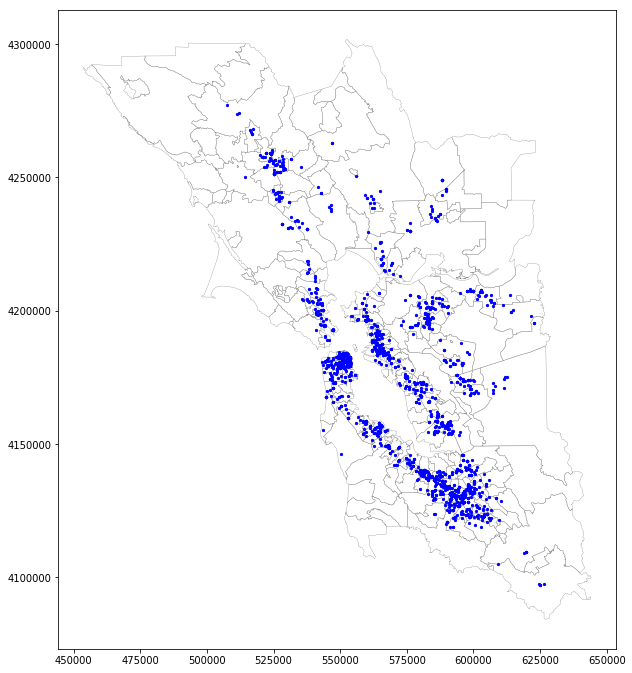

In [13]:
# plot houses on bay area map
base = zips.plot(color='none', edgecolor='gray', linewidth=.3, figsize=(10,20))
house_bay_proj.plot(ax=base, color="b", markersize=5)

In [14]:
house_bay_proj.describe()

,rent,bedroom,ft2,longitude,latitude,index_right,ZIPCODE_ID,AREA,POPULATION,FAMILIES,...,FEMALE_WID,FEMALE_DIV,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI
count,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,...,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,3165.356517,1.973713,1134.776013,-122.168639,37.694357,122.553122,123.553122,21.676421,33596.162651,8138.559146,...,1311.310515,1651.113910,22925.578313,228.633078,6.120482,44.509858,38.292442,52.340635,259.496166,193.445783
std,1606.994795,0.933028,941.839305,0.255893,0.326365,70.618091,70.618091,52.376438,15537.047011,4026.589117,...,676.321440,769.257347,10679.235620,134.973999,11.883164,42.450424,36.963468,51.594362,301.892437,160.376924
min,1075.000000,1.000000,80.000000,-122.915128,37.012183,1.000000,2.000000,0.074413,750.000000,91.000000,...,11.000000,29.000000,478.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2300.250000,1.000000,750.000000,-122.391187,37.390764,62.000000,63.000000,3.596290,23285.000000,5196.000000,...,862.000000,1118.000000,15904.750000,125.000000,0.000000,10.000000,13.000000,15.000000,51.000000,87.000000
50%,2795.000000,2.000000,976.500000,-122.095030,37.707435,102.000000,103.000000,6.983250,31935.000000,8049.000000,...,1271.000000,1662.000000,22888.000000,218.000000,0.000000,31.000000,28.000000,40.000000,138.000000,147.000000
75%,3537.750000,2.000000,1224.250000,-121.966268,37.881528,180.000000,181.000000,17.653500,46292.000000,11537.000000,...,1667.000000,2153.000000,29772.000000,326.000000,8.000000,68.750000,53.000000,76.000000,344.000000,266.000000
max,25995.000000,7.000000,26000.000000,-121.577300,38.642435,265.000000,266.000000,465.220000,76117.000000,17843.000000,...,4080.000000,4026.000000,54830.000000,607.000000,62.000000,193.000000,205.000000,437.000000,1621.000000,1167.000000


In [15]:
zip_city = pd.read_csv("data/zip_city.csv").iloc[:,1:4]
zip_city.head()

,Zip Code,City,County
0,90001.0,Los Angeles,Los Angeles
1,90002.0,Los Angeles,Los Angeles
2,90003.0,Los Angeles,Los Angeles
3,90004.0,Los Angeles,Los Angeles
4,90005.0,Los Angeles,Los Angeles


In [16]:
house_bay_proj["ZIP_CODE_5"] = house_bay_proj["ZIP_CODE_5"].astype(float)

In [17]:
house_bay_city_proj = pd.merge(house_bay_proj, zip_city, how="left", left_on="ZIP_CODE_5", right_on="Zip Code")
house_bay_city_proj = house_bay_city_proj.drop(["index_right", "Zip Code"], axis=1)
house_bay_city_proj.head(3)

,pid,name,rent,bedroom,ft2,longitude,latitude,geometry,ZIPCODE_ID,ZIP_CODE_5,...,LANG_ENGLI,LANG_GERMA,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI,City,County
0,6738315713,AMENITIES! GYM AND POOL! 1 BEDROOM WITH ATTACH...,2282.0,1.0,950.0,-121.915500,37.763600,POINT (595522.4836904225 4180140.146306456),206,94583.0,...,28939,254,0,53,34,55,248,114,San Ramon,Contra Costa
1,6739988934,$99 Deopsit 2bed/2bath home! Make It Yours!,2613.0,2.0,1175.0,-121.966610,37.757127,POINT (591028.5346182709 4179370.992834613),206,94583.0,...,28939,254,0,53,34,55,248,114,San Ramon,Contra Costa
2,6739987158,Spacious Renovated 2bed/2bath home! Make It Yo...,2562.0,2.0,1175.0,-121.966546,37.757161,POINT (591034.1306916426 4179374.827474921),206,94583.0,...,28939,254,0,53,34,55,248,114,San Ramon,Contra Costa


# Clean Data

## Number of housings

In [18]:
city_rent = house_bay_city_proj["rent"].groupby(by=house_bay_city_proj["City"]).agg(["count", "min", "max", "mean", "median"]).\
            sort_values("count", ascending=False)
city_rent_filtered = city_rent[city_rent["count"]>=5]
city_rent_filtered.head()

,count,min,max,mean,median
City,,,,,
San Jose,239,1075.0,5134.0,2843.380753,2768.0
San Francisco,228,1200.0,25000.0,4925.811404,4500.0
Oakland,77,1249.0,6400.0,2764.649351,2705.0
Santa Clara,76,1499.0,4410.0,2726.460526,2780.5
Santa Rosa,74,1076.0,4300.0,2383.297297,2325.0


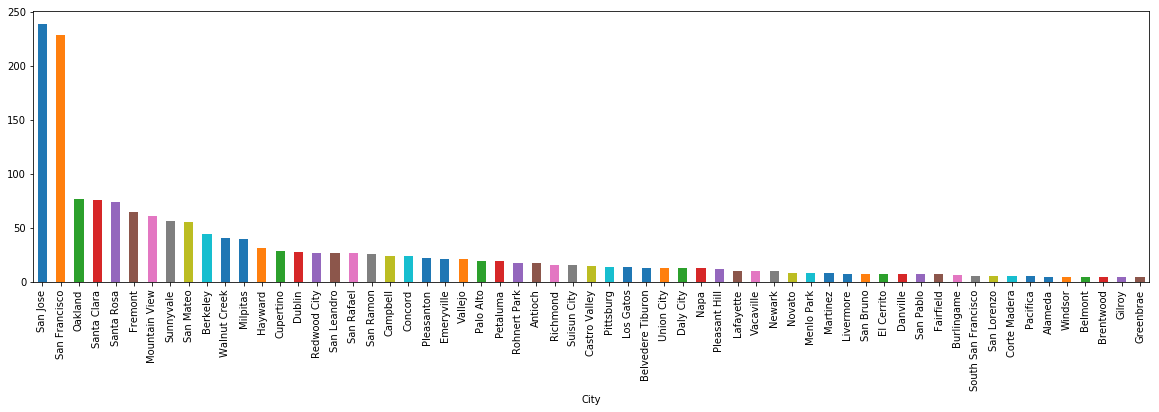

In [19]:
city_rent_filtered["count"].plot(kind="bar", figsize=(20,5))

In [20]:
county_rent = house_bay_city_proj["rent"].groupby(by=house_bay_city_proj["County"]).agg(["count", "min", "max", "mean", "median"]).\
            sort_values("count", ascending=False)
county_rent_filtered = county_rent[county_rent["count"]>=5]
county_rent_filtered.head()

,count,min,max,mean,median
County,,,,,
Santa Clara,576,1075.0,10500.0,3022.784722,2795.0
Alameda,379,1175.0,6400.0,2771.340369,2585.0
San Francisco,228,1200.0,25000.0,4925.811404,4500.0
Contra Costa,211,1155.0,25995.0,2676.895735,2395.0
San Mateo,146,2000.0,9500.0,3606.479452,3397.0


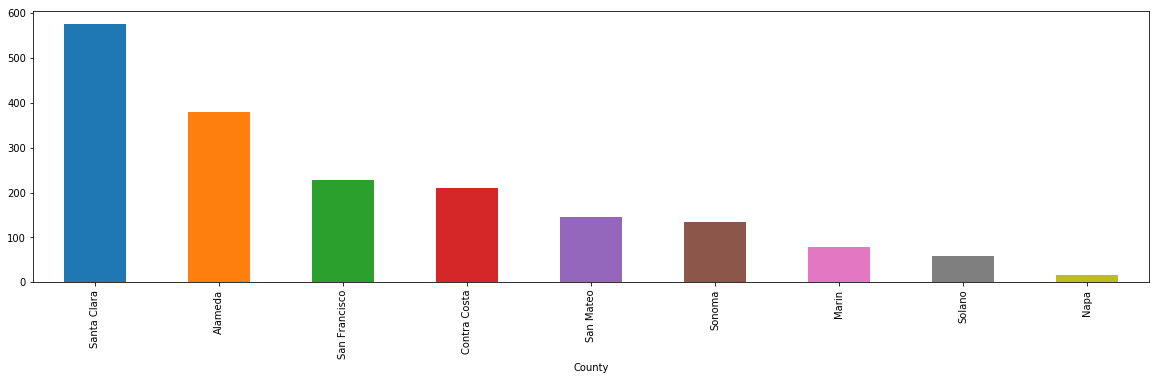

In [21]:
county_rent_filtered["count"].plot(kind="bar", figsize=(20,5))

In [22]:
zips["ZIP_CODE_5"] = zips["ZIP_CODE_5"].astype(float)
zips_census_city = pd.merge(zips,zip_city, how="left", left_on="ZIP_CODE_5", right_on="Zip Code")
zips_census_city.head()

,ZIPCODE_ID,ZIP_CODE_5,AREA,POPULATION,FAMILIES,HOUSEHOLDS,MALE,FEMALE,WHITE,BLACK,...,LANG_YIDDI,LANG_OTH_W,LANG_SCAND,LANG_GREEK,LANG_INDIC,LANG_ITALI,geometry,Zip Code,City,County
0,1,94060.0,48.31930,742,113,143,497,245,634,0,...,0,0,0,0,7,0,"POLYGON ((562950.8783921932 4107065.91013016, ...",94060.0,Pescadero,San Mateo
1,2,94038.0,7.55713,5438,1432,1923,2736,2702,5105,58,...,0,0,0,0,0,56,"POLYGON ((544293.1225337704 4150326.120247032,...",94038.0,Moss Beach,San Mateo
2,3,94044.0,14.56850,37604,9755,13299,18817,18787,28829,1824,...,5,59,85,160,135,220,"POLYGON ((542473.6490735016 4158682.054415229,...",94044.0,Pacifica,San Mateo
3,4,94015.0,5.60663,57539,14052,18845,28076,29463,23944,4289,...,37,18,26,437,286,338,"POLYGON ((544671.5632409335 4168667.932970844,...",94015.0,Daly City,San Mateo
4,5,94080.0,9.68049,54562,13876,18715,26807,27755,33754,2097,...,0,18,5,338,406,895,"POLYGON ((554183.8416124377 4169368.309210085,...",94080.0,South San Francisco,San Mateo


In [23]:
city_pop = pd.DataFrame(zips_census_city["POPULATION"].groupby(by=zips_census_city["City"]).sum()).reset_index()
city_house = city_rent_filtered["count"].reset_index()

In [24]:
city_house_pop = pd.merge(city_pop,city_house,how="right")
city_house_pop.head()

,City,POPULATION,count
0,Alameda,76117,5
1,Antioch,62839,18
2,Belmont,24875,5
3,Belvedere Tiburon,11011,13
4,Berkeley,103956,45


/Users/takuma/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/takuma/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/takuma/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


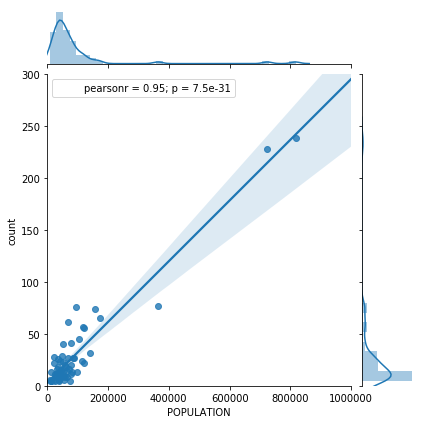

In [25]:
sns.jointplot("POPULATION", "count", data=city_house_pop, kind="reg", xlim=(0,1000000), ylim=(0,300))

# Housing rents

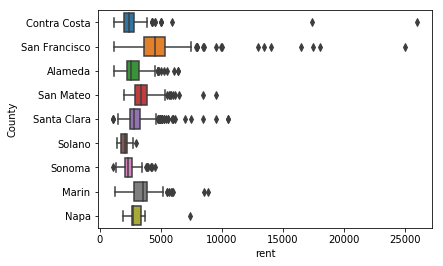

In [26]:
sns.boxplot(x="rent",y="County",data=house_bay_city_proj)

/Users/takuma/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


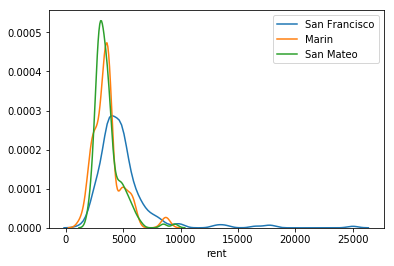

In [27]:
for county in ["San Francisco", "Marin", "San Mateo"]:
    sns.distplot(house_bay_city_proj[house_bay_city_proj["County"]==county]["rent"], hist=False, kde=True, label=county)

In [28]:
house_bay_city_proj["County"].unique()

array(['Contra Costa', 'San Francisco', 'Alameda', 'San Mateo',
       'Santa Clara', 'Solano', 'Sonoma', 'Marin', 'Napa'], dtype=object)

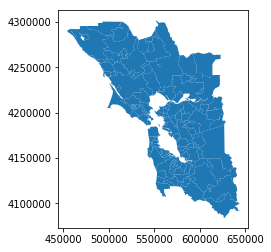

In [29]:
city_proj = zips_census_city.dissolve(by="City")
city_proj.plot()

In [30]:
city_rent_proj = pd.merge(city_proj, city_rent, how="left", right_on="City", left_on="City").fillna(0)
city_rent_proj.head()

,geometry,ZIPCODE_ID,ZIP_CODE_5,AREA,POPULATION,FAMILIES,HOUSEHOLDS,MALE,FEMALE,WHITE,...,LANG_GREEK,LANG_INDIC,LANG_ITALI,Zip Code,County,count,min,max,mean,median
City,,,,,,,,,,,,,,,,,,,,,
Alameda,(POLYGON ((566524.7993867351 4175649.740930626...,187,94501.0,10.68890,76117,17843,29235,40234,35883,53190,...,65,92,381,94501.0,Alameda,5.0,2308.0,3318.0,2667.4,2466.0
Alamo,"POLYGON ((587336.3322380445 4191966.985328517,...",207,94507.0,8.32917,8759,2654,3112,4320,4439,8288,...,6,27,73,94507.0,Contra Costa,1.0,4500.0,4500.0,4500.0,4500.0
Albany,"POLYGON ((560187.527374733 4193797.925584279, ...",184,94706.0,1.55866,17172,4530,7678,7955,9217,12098,...,0,88,185,94706.0,Alameda,2.0,2800.0,3095.0,2947.5,2947.5
Alviso,"POLYGON ((589336.4924058581 4143453.342149185,...",70,95002.0,5.34845,2190,489,571,1253,937,1897,...,0,0,6,95002.0,Santa Clara,0.0,0.0,0.0,0.0,0.0
Angwin,"POLYGON ((543198.7947576032 4267723.669300478,...",195,94508.0,24.04400,4106,788,1004,2073,2033,3426,...,0,0,8,94508.0,Napa,0.0,0.0,0.0,0.0,0.0


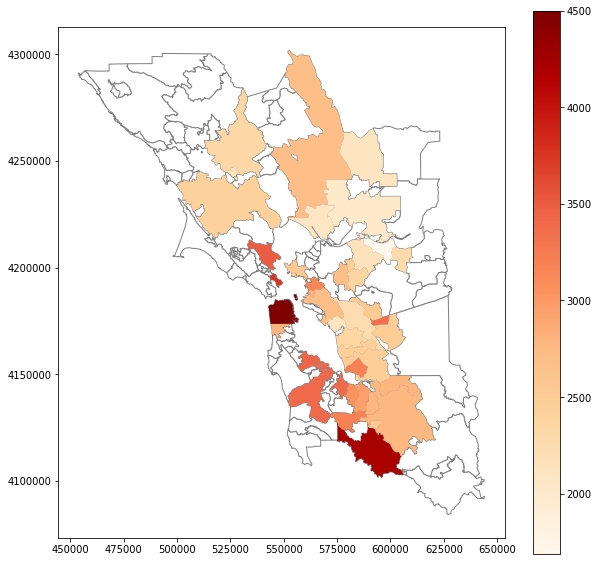

In [31]:
base = city_proj.plot(color="white", edgecolor ="gray", figsize=(10,10))
city_rent_proj[city_rent_proj["count"]>=10].plot(column='median', figsize=(14,10), cmap='OrRd', legend=True, ax=base)

# Prediction modeling

In [33]:
house_bay_proj

ValueError: Must pass DataFrame with boolean values only